In [1]:
import numerox as nx
import pandas as pd
import numpy as np

import scipy
import scipy.cluster.hierarchy as sch
from sklearn import metrics

%matplotlib inline
import matplotlib.pyplot as plt

from xgboost.sklearn import XGBRegressor
import xgboost as xgboost

In [11]:
#load the latest data
data = nx.load_zip('numerai_datasets_new.zip')

In [12]:
#new data has extra era of test data and ofcourse the live data
data.region_isin(['test'])

region    test
rows      1526016
era       301, [era575, era923]
x         310, min 0.0000, mean 0.5000, max 1.0000
y         mean 0.499981, fraction missing 0.1250

In [19]:
#The last era of the test region is the new test era
NEW_ERA = 'era923'

In [20]:
new_test_era = data.era_isin([NEW_ERA])

In [21]:
live_era = data.region_isin(['live'])

In [22]:
def createCorrClusters(col_start, col_end, era_strs, verbose=0 ):
    """
    create correlation clusters for each era in era_strs. It works on the global data
    
    Input: 
        col_start: start column id for creating the correlation cluster
        col_end: end column id for creating the correlation cluster
        era_strs: array of era names for which correlation clusters need to be computed one-by-one
    
    Output:
        newdf: A new dataframe where era_strs correspond to rows while the features of 
                    original data sorted on cluster id serve as the columns. The values  are the cluster ids
        eraDfs: A simple dictionary holding eraName -> original data with columns sorted by cluster id
        
    """
    
    eraDfs = {}
    created = False
    #for i in range(num_eras):
    for eraStr in era_strs:
        
        #Get the dataframe for the era from col_start to col_end
        validdf = data.era_isin([eraStr]).df.iloc[:, col_start:col_end]
        if verbose:
            print("Generating clusters for era %s" % eraStr)
            
        #Compute the correlation among the features using spearman method
        #as it can measure non-linear relationship between the features
        X = validdf.corr(method='spearman').values

        d = sch.distance.pdist(X)   # vector of ('50' choose 2) pairwise distances
        
        #Perform hierarchical clustering based on the distance between correlation values
        L = sch.linkage(d, method='complete')
        #flatten the hierarchical clustering to generate cluster id for each feature
        ind = sch.fcluster(L, 0.5*d.max(), 'distance')
        
        #sort the columns of the original dataframe based on the cluster ids
        columns = [validdf.columns.tolist()[i] for i in list((np.argsort(ind)))]
        validdf = validdf.reindex(columns, axis=1)
        if created == False:
            newdf = pd.DataFrame([ind], index=[eraStr])
            created = True
        else:
            tmpdf = pd.DataFrame([ind], index=[eraStr])
            newdf = newdf.append(tmpdf)
        eraDfs[eraStr] = validdf
        
    return newdf, eraDfs

In [23]:
def modelfit(alg, xtrain, ytrain, era_list, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgboost.DMatrix(xtrain, ytrain)
        cvresult = xgboost.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='rmse', early_stopping_rounds=early_stopping_rounds, verbose_eval=True)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(xtrain, ytrain,eval_metric='rmse')
        
    #Predict training set:
    dtrain_predictions = alg.predict(xtrain)
    dpreSeries = pd.Series(dtrain_predictions, index=data.era_isin(era_list).df.index)
    
    rankedPred = dpreSeries.rank(pct=True, method='first')
    
    #Print model report:
    print("\nModel Report")
    print("Correlation is : %.4g" % np.corrcoef(ytrain, rankedPred)[0,1])
                        
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [24]:
#A simple XGBoost model with 100 estimators
def fit_xgb_model( eras_list, estimators=100):
    trainX = data.era_isin(eras_list).x
    trainY = data.era_isin(eras_list).y['kazutsugi']
    
    xgb = XGBRegressor(
             learning_rate =0.01,
             n_estimators= estimators,
             booster='gbtree',
             base_score=0.5,
             max_depth=7,
             min_child_weight=2,
             gamma=0,
             subsample=0.7,
             colsample_bytree=0.7,
             objective= 'reg:squarederror',
             nthread=8,
             scale_pos_weight=1,
             random_state=1)

    modelfit(xgb, trainX, trainY, eras_list)
    return xgb

In [25]:
#Read existing cluster data
orig_fset_corrcluster = pd.read_hdf("corr_cluster_test_922.hdf", key='df')

#create the correlation cluster for the new test era
test_corrcluster, test_corr = createCorrClusters(2,312, [NEW_ERA], verbose=1)
#append the new cluster data to the original one
common_fset_corr = pd.concat([orig_fset_corrcluster, test_corrcluster], axis=0)

Generating clusters for era era923


In [26]:
#create the correlation clusters for the live era 
live_corrcluster, live_corr = createCorrClusters(2,312, ['eraX'], verbose=1)
#append the live cluster data to the existing cluster data
total_corrcluster = pd.concat([common_fset_corr, live_corrcluster], axis=0)

Generating clusters for era eraX


In [27]:
def get_similar_eras(era_str, total_corrcluster, threshold=0.7):
    '''
    return list of train & validation eras that have similar clustering
    to the era_str passed
    
    Input:
    era_str : name of the era for which similar eras need to be returned
    total_corrcluster : correlation cluster data
    threshold : eras that have a similarity score above this threshold will be selected
    
    Output:
    era_lst : list of similar eras
    
    '''
    train_era_arr = np.unique(data.region_isin(['train', 'validation']).era)
    train_era_strs = data.eras_int2str(train_era_arr)
    base_fset =  total_corrcluster.loc[[era_str]].values[0]
    eras_lst = []
    for test_era in train_era_strs:
    
        test_fset = total_corrcluster.loc[[test_era]].values[0]
        score1 = metrics.adjusted_rand_score(base_fset, test_fset)
        score2 = metrics.adjusted_mutual_info_score(base_fset, test_fset, average_method='geometric' )
        if score2 > threshold:
            eras_lst.append(test_era)
            print("test_era %s score is %g and %g "% (test_era, score1, score2))
    
    return eras_lst

test_era era107 score is 0.597298 and 0.702547 
test_era era92 score is 0.512203 and 0.703274 
[0]	train-rmse:0.352547+0.00047829	test-rmse:0.352976+0.00182413
[1]	train-rmse:0.3521+0.000454289	test-rmse:0.352959+0.00184128
[2]	train-rmse:0.351653+0.000463676	test-rmse:0.352922+0.00181885
[3]	train-rmse:0.35119+0.000488656	test-rmse:0.352898+0.00183369
[4]	train-rmse:0.350734+0.000495967	test-rmse:0.352883+0.00181924
[5]	train-rmse:0.350295+0.000507168	test-rmse:0.352894+0.00181219
[6]	train-rmse:0.349839+0.0005104	test-rmse:0.352875+0.0018175
[7]	train-rmse:0.349377+0.000518914	test-rmse:0.352855+0.00180949
[8]	train-rmse:0.348925+0.000521148	test-rmse:0.352802+0.00180957
[9]	train-rmse:0.34848+0.000536296	test-rmse:0.352773+0.00179299
[10]	train-rmse:0.348014+0.000525394	test-rmse:0.352745+0.0017725
[11]	train-rmse:0.347551+0.000521806	test-rmse:0.352718+0.00176538
[12]	train-rmse:0.347093+0.000520576	test-rmse:0.352719+0.00176232
[13]	train-rmse:0.346638+0.000523093	test-rmse:0.3527

[122]	train-rmse:0.30326+0.000903124	test-rmse:0.351659+0.00162406
[123]	train-rmse:0.302895+0.000900863	test-rmse:0.351654+0.00160175
[124]	train-rmse:0.302549+0.000896659	test-rmse:0.351668+0.00159916
[125]	train-rmse:0.302174+0.000891175	test-rmse:0.351651+0.00162081
[126]	train-rmse:0.30181+0.000912131	test-rmse:0.35164+0.00161092
[127]	train-rmse:0.301431+0.000917137	test-rmse:0.351646+0.00160574
[128]	train-rmse:0.301062+0.000924989	test-rmse:0.351643+0.00161757
[129]	train-rmse:0.300694+0.000908267	test-rmse:0.351627+0.00162787
[130]	train-rmse:0.300343+0.000919016	test-rmse:0.351645+0.00163865
[131]	train-rmse:0.299992+0.000922491	test-rmse:0.351636+0.00164768
[132]	train-rmse:0.299637+0.000923391	test-rmse:0.351611+0.00162636
[133]	train-rmse:0.299294+0.000924693	test-rmse:0.351586+0.00161389
[134]	train-rmse:0.298919+0.000935667	test-rmse:0.35157+0.00159864
[135]	train-rmse:0.298581+0.000959074	test-rmse:0.351583+0.00159019
[136]	train-rmse:0.298243+0.000958155	test-rmse:0.35

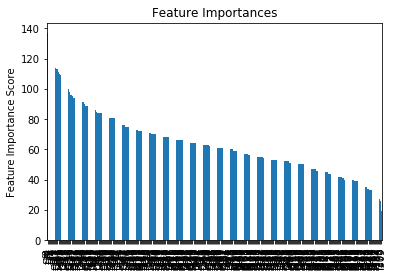

In [28]:
#find out the eras with similar correlation clustering wrt live era
live_era_lst = get_similar_eras('eraX', total_corrcluster)

#fit a standard XGBoost model on the selected eras as training data
live_model = fit_xgb_model(live_era_lst, 1000)

#generate predictions
liveX = data.era_isin(['eraX']).x
liveY = data.era_isin(['eraX']).y['kazutsugi']
dlive_predictions = live_model.predict(liveX)

In [29]:
#create a dataframe out of the predictions
df_live_pred = pd.DataFrame(dlive_predictions, index=data.era_isin(['eraX']).df.index, columns=["prediction_kazutsugi"])

In [30]:
#read the example predictions that will serve as dummy predictions for validation and test regions
ex_preds = pd.read_csv("example_predictions_target_kazutsugi.csv", index_col=0)

In [31]:
#Take out the live era from the example predictions 
dummy_preds = ex_preds.iloc[:ex_preds.shape[0] -  data.era_isin(['eraX']).df.shape[0]]

In [32]:
#Append the generated predictions to the dummy predictions to generate the predictions that can be submitted
#Note that Numerai will score only for the 'live' predictions but it requires submission of all validation and test 
#region data as well and in an ordered fashion
final_df = dummy_preds.append(df_live_pred)

In [33]:
#Save the dataframe to a csv file and submit on the platform
final_df.to_csv("submit.csv")